In [64]:
import pandas as pd

data1km = pd.read_csv('/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/MODIS_L2/daily_chunks/chunk_2020_001_020_5km.csv')
data1km = data1km.sort_values(by = ["grid_id","year","day"])
data1km.to_csv("/Users/anora/Documents/GitHub/CloudSeeding/code/energy_flux/test/test.csv")

In [65]:
pd.set_option('display.max_rows', 500)
data1km.head(5)

,Unnamed: 0,year,day,grid_id,Cloud_Fraction,Cloud_Fraction_Nadir,Cloud_Fraction_Night,Cloud_Fraction_Nadir_Night,Cloud_Fraction_Day,Cloud_Fraction_Nadir_Day,point_count
0,0,2020,1,0.0,0.000,NaN,0.000000,NaN,NaN,NaN,3
3722,0,2020,2,0.0,1.000,1.000000,NaN,NaN,1.00,1.0,4
10503,0,2020,3,0.0,1.000,1.000000,1.000000,1.000000,NaN,NaN,4
16167,0,2020,4,0.0,0.000,NaN,NaN,NaN,0.00,NaN,2
21523,0,2020,5,0.0,0.208,0.053333,0.053333,0.053333,0.44,NaN,5


<Axes: >

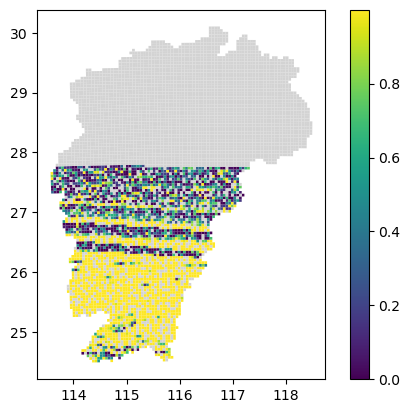

In [72]:
import geopandas as gpd
grid_latlon = gpd.read_file('/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/MODIS_L2/grid_latlon.shp')
data = data1km[data1km['day']==20].merge(grid_latlon, on = ['grid_id'], how = "right")
geo_data = gpd.GeoDataFrame(data, geometry = data["geometry"])
geo_data.plot(column="Cloud_Fraction",legend=True,missing_kwds={'color': 'lightgrey'})

<Axes: >

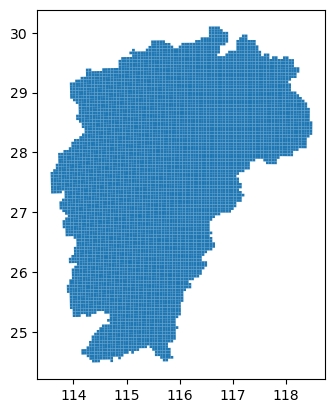

In [54]:
grid_latlon.plot()

Plotting global coverage for 2020-020
Found 288 files


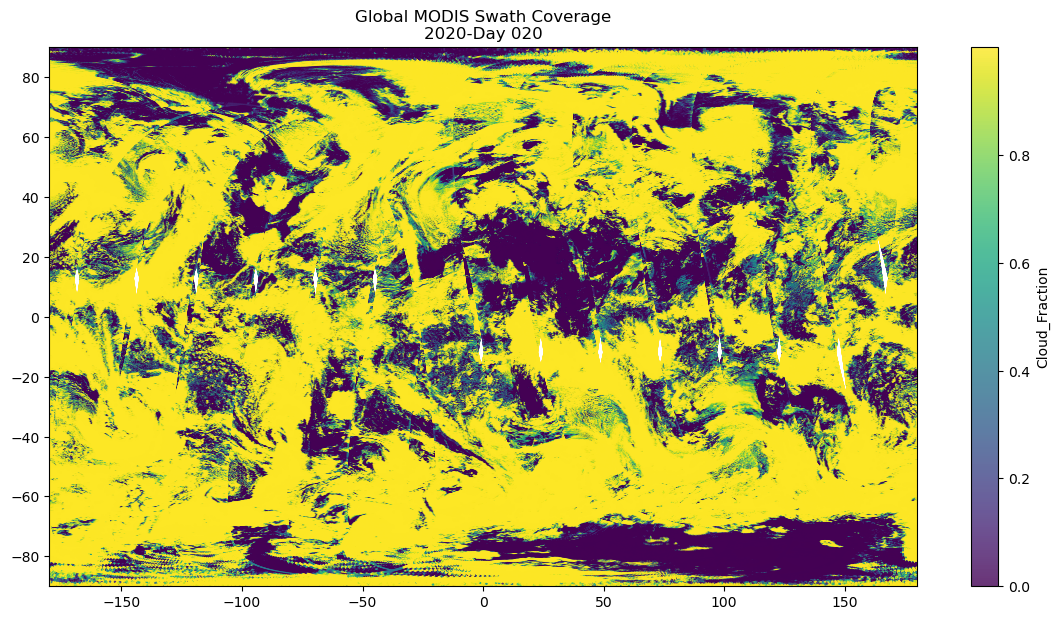

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr

def plot_global_day(year, day, cloud_file="MOD06_L2", var="Cloud_Fraction"):
    print(f"Plotting global coverage for {year}-{day}")

    fig, ax = plt.subplots(figsize=(14,7))

    cloud_paths = sorted(
        glob.glob(f"{cloud_file}/{year}/{day}/{cloud_file}.A{year}{day}.*.hdf")
    )
    print("Found", len(cloud_paths), "files")

    for cp in cloud_paths:
        try:
            cloud = xr.open_dataset(cp, engine="netcdf4", decode_times=False, mask_and_scale=True)

            # 5 km 经纬度
            lat = cloud["Latitude"].data
            lon = cloud["Longitude"].data
            dat = cloud[var].data

            mask = np.isfinite(lat) & np.isfinite(lon) & np.isfinite(dat)

            ax.scatter(
                lon[mask], lat[mask],
                c=dat[mask],
                cmap="viridis",
                s=0.4, alpha=0.8
            )

            cloud.close()

        except Exception as e:
            print("Error reading file:", cp, e)
            continue

    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_title(f"Global MODIS Swath Coverage\n{year}-Day {day}")

    plt.colorbar(ax.collections[-1], ax=ax, label=var)
    plt.show()

    
plot_global_day("2020", "020")

In [78]:
  # load data
townshape = gpd.read_file('/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/township_shapefile/xiangzhen.shp')

# data clean
townshape = townshape[townshape['省'] == "江西省"]
townshape = townshape[['省','市','县','乡','geometry']]
townshape.columns = ["prov","city","county","town","geometry"]
townshape = townshape.reset_index(drop=True)
townshape["geometry"] = townshape["geometry"].buffer(0)

# Two types exists: polygon and multipolygon, all convert 
# to multipolygon to avoid geometry issues
townshape['geometry'] = townshape['geometry'].apply(
    lambda g: MultiPolygon([g]) if g.geom_type == 'Polygon' else g
)
# Dissolve
jiangxi_shape = townshape.dissolve()[['geometry','prov']].to_crs('EPSG:4326')
jx_poly = jiangxi_shape.geometry.iloc[0]

Plotting Jiangxi-only coverage (with missing in gray) for 2020-020
Found 288 files


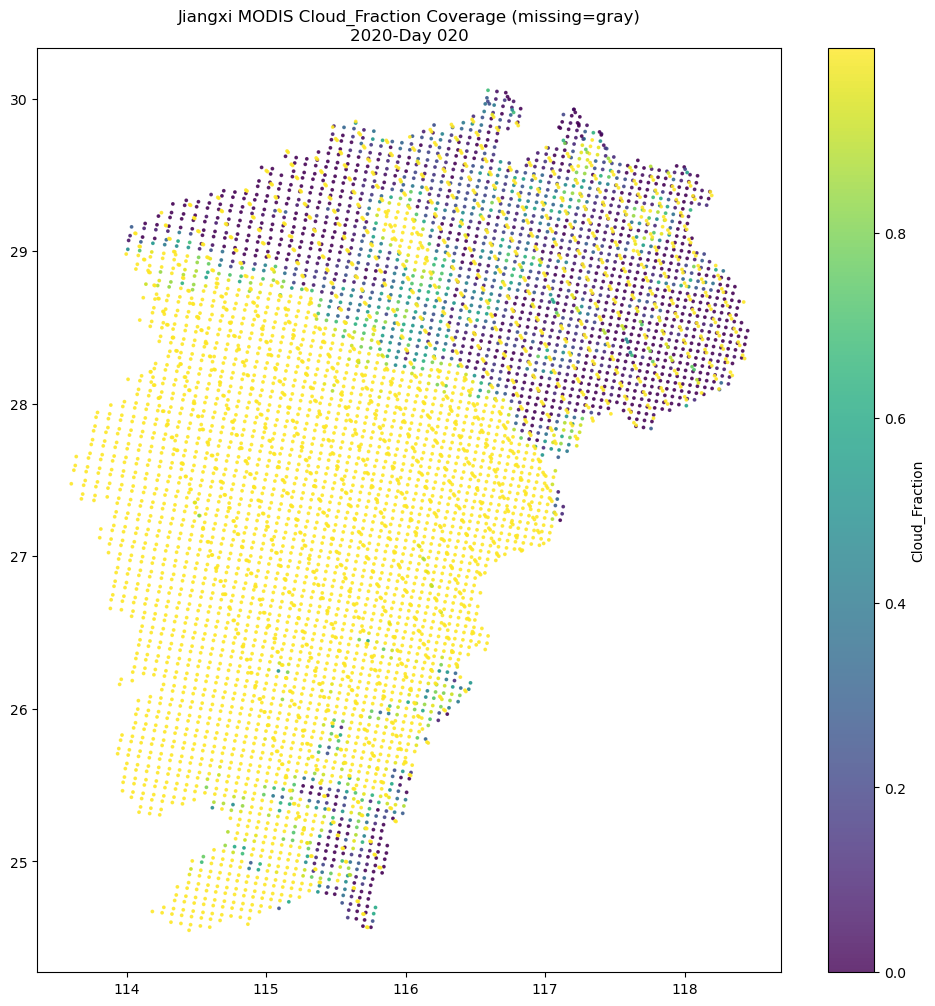

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
from shapely.geometry import Point

def plot_global_day_jx(year, day, jx_poly, cloud_file="MOD06_L2", var="Cloud_Fraction"):
    print(f"Plotting Jiangxi-only coverage (with missing in gray) for {year}-{day}")

    fig, ax = plt.subplots(figsize=(12, 12))

    cloud_paths = sorted(
        glob.glob(f"{cloud_file}/{year}/{day}/{cloud_file}.A{year}{day}.*.hdf")
    )
    print("Found", len(cloud_paths), "files")

    # 江西 bounding box
    minx, miny, maxx, maxy = jx_poly.bounds

    for cp in cloud_paths:
        try:
            cloud = xr.open_dataset(cp, engine="netcdf4", decode_times=False, mask_and_scale=True)

            lat = cloud["Latitude"].data
            lon = cloud["Longitude"].data
            dat = cloud[var].data

            # 1) 落在江西 bbox 内（快速）
            in_bbox = (lon >= minx) & (lon <= maxx) & (lat >= miny) & (lat <= maxy)
            if np.sum(in_bbox) == 0:
                cloud.close()
                continue

            # bbox 内的点
            lon_sub = lon[in_bbox]
            lat_sub = lat[in_bbox]
            dat_sub = dat[in_bbox]

            # 2) 精筛选：真正落在江西省 boundary 内
            inside = np.array([jx_poly.contains(Point(x, y)) for x, y in zip(lon_sub, lat_sub)], dtype=bool)
            if np.sum(inside) == 0:
                cloud.close()
                continue

            lon_jx = lon_sub[inside]
            lat_jx = lat_sub[inside]
            dat_jx = dat_sub[inside]

            # --- Missing 点：灰色 ---
            miss = ~np.isfinite(dat_jx)
            if np.sum(miss) > 0:
                ax.scatter(
                    lon_jx[miss], lat_jx[miss],
                    c="lightgray", s=3, alpha=0.8
                )

            # --- 有效点：彩色 ---
            valid = np.isfinite(dat_jx)
            if np.sum(valid) > 0:
                sc = ax.scatter(
                    lon_jx[valid], lat_jx[valid],
                    c=dat_jx[valid],
                    cmap="viridis",
                    s=3, alpha=0.8
                )

            cloud.close()

        except Exception as e:
            print("Error reading:", cp, e)
            continue

    ax.set_title(f"Jiangxi MODIS {var} Coverage (missing=gray)\n{year}-Day {day}")
    plt.colorbar(sc, ax=ax, label=var)
    plt.show()

plot_global_day_jx("2020", "020", jx_poly)

In [81]:
import numpy as np
import xarray as xr
import glob
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

def daily_grid_jx_5km(year, day, jx_poly, 
                      cloud_file="MOD06_L2", var="Cloud_Fraction",
                      grid_size=5000):
    
    print(f"Constructing Jiangxi 5km grid for {year}-{day}")

    # --- 1) 江西 polygon 投影到 EPSG:4527 ---
    jx_proj = gpd.GeoSeries([jx_poly], crs="EPSG:4326").to_crs("EPSG:4527").iloc[0]
    minx, miny, maxx, maxy = jx_proj.bounds

    # --- 2) 构建 5km × 5km 投影格网 ---
    x_bins = np.arange(minx, maxx + grid_size, grid_size)
    y_bins = np.arange(miny, maxy + grid_size, grid_size)

    # 容器
    sum_grid = np.zeros((len(y_bins)-1, len(x_bins)-1))
    count_grid = np.zeros((len(y_bins)-1, len(x_bins)-1))

    # 经纬度→投影转换器
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:4527", always_xy=True)

    # ---- 3) 读取所有 swath 文件 ----
    cloud_paths = sorted(
        glob.glob(f"{cloud_file}/{year}/{day}/{cloud_file}.A{year}{day}.*.hdf")
    )
    print("Found", len(cloud_paths), "files")

    for cp in cloud_paths:
        try:
            cloud = xr.open_dataset(cp, engine="netcdf4", decode_times=False, mask_and_scale=True)

            lat = cloud["Latitude"].data
            lon = cloud["Longitude"].data
            dat = cloud[var].data

            # 先过滤 NaN
            mask = np.isfinite(lat) & np.isfinite(lon) & np.isfinite(dat)
            lat = lat[mask]
            lon = lon[mask]
            dat = dat[mask]

            # 经纬度 → EPSG:4527 (x, y meters)
            xs, ys = transformer.transform(lon, lat)

            # 落在 bbox 内
            inbbox = (xs >= minx) & (xs <= maxx) & (ys >= miny) & (ys <= maxy)

            if np.sum(inbbox) == 0:
                cloud.close()
                continue

            xs = xs[inbbox]
            ys = ys[inbbox]
            dat = dat[inbbox]

            # 精筛选：在江西 boundary 内
            inside = np.array([jx_proj.contains(Point(x, y)) for x, y in zip(xs, ys)])
            if np.sum(inside) == 0:
                cloud.close()
                continue

            xs = xs[inside]
            ys = ys[inside]
            dat = dat[inside]

            # histogram2d 做 5km gridding
            H_sum = np.histogram2d(ys, xs, bins=[y_bins, x_bins], weights=dat)[0]
            H_cnt = np.histogram2d(ys, xs, bins=[y_bins, x_bins])[0]

            sum_grid += H_sum
            count_grid += H_cnt

            cloud.close()

        except Exception as e:
            print("Error:", cp, e)
            continue

    # --- 4) 最终平均值 ---
    mean_grid = sum_grid / count_grid
    mean_grid[count_grid == 0] = np.nan

    return mean_grid, x_bins, y_bins

mean_grid, x_bins, y_bins = daily_grid_jx_5km("2020", "020", jx_poly)

Constructing Jiangxi 5km grid for 2020-020
Found 288 files


In [ ]:
mean_grid


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Constructing Jiangxi 5km grid for 2020-020
Found 288 files


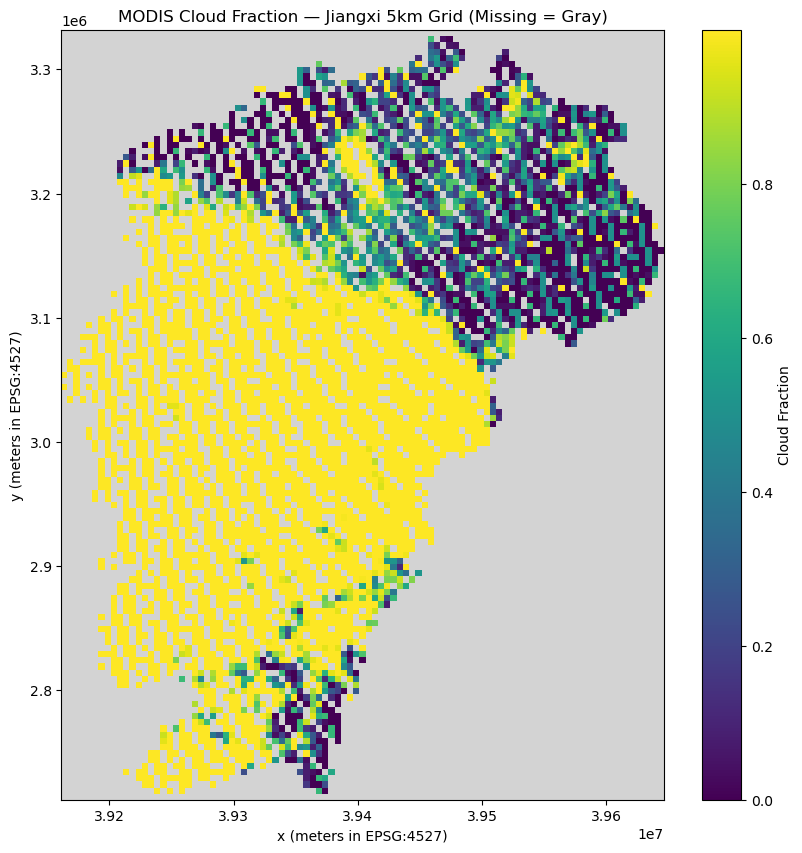

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def plot_5km_grid(mean_grid, x_bins, y_bins, title=""):
    plt.figure(figsize=(10, 10))

    # 自定义 colormap：加一个灰色用于 NaN
    from matplotlib.colors import LinearSegmentedColormap
    cmap = plt.get_cmap("viridis")
    # 添加一行灰色作为 NaN color
    cmap_with_gray = cmap.with_extremes(bad="lightgray")

    plt.imshow(
        mean_grid,
        origin="lower",
        cmap=cmap_with_gray,
        extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]]
    )

    plt.colorbar(label="Cloud Fraction")
    plt.title(title)
    plt.xlabel("x (meters in EPSG:4527)")
    plt.ylabel("y (meters in EPSG:4527)")

    plt.show()

mean_grid, x_bins, y_bins = daily_grid_jx_5km("2020", "020", jx_poly)

plot_5km_grid(
    mean_grid,
    x_bins,
    y_bins,
    title="MODIS Cloud Fraction — Jiangxi 5km Grid (Missing = Gray)"
)

[3.86267495 2.50746298 1.40301929] [1.49603291 0.41460722 1.15814378]


array([[0., 0., 0., 0.],
       [2., 0., 0., 0.],
       [1., 0., 0., 0.]])

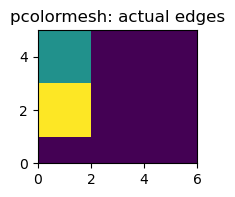

In [127]:
import numpy as np
import matplotlib.pyplot as plt

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]

x = np.random.normal(2, 1, 3)
y = np.random.normal(1, 1, 3)
print(x,y)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(132, title='pcolormesh: actual edges', aspect='equal')
plt.pcolormesh(yedges,xedges, H)

H


In [129]:
sum_grid = np.zeros((1, 3))
sum_grid

array([[0., 0., 0.]])

In [130]:
H.shape

(3, 4)